# Import Libraries

In [35]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.templates.default = "simple_white"
import tensorflow as tf
import os
import warnings
warnings.filterwarnings(action='ignore')

# Sign Language EDA

Our goal is to classify American Sign Language (ASL) alphabet video files with short sentences using lips/hand landmarks.


Here is an example of one landmarks data..

<img src="https://developers.google.com/static/mediapipe/images/solutions/hand-landmarks.png" width="750">
<p><a href="https://developers.google.com/mediapipe/solutions/vision/hand_landmarker">reference</a></p>


# Loading Dataset

In [4]:
df = pd.read_csv("asl-fingerspelling/train.csv")

# Data Description

In [5]:
df.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


The phrases in the training set contains random websites/addresses/phone numbers.

In [6]:
print(f"Total number of files : {df.shape[0]}")
print(f"Total number of Participant in the dataset : {df.participant_id.nunique()}")
print(f"Total number of unique phrases : {df.phrase.nunique()}")

Total number of files : 67208
Total number of Participant in the dataset : 94
Total number of unique phrases : 44601


# Data Dictionary

`path` - The path to the landmark file. <br>
`file_id` - A unique identifier for the data file. <br>
`participant_id` - A unique identifier for the data contributor. <br>
`sequence_id` - A unique identifier for the landmark sequence. Each data file may contain many sequences. <br>
`phrase` - The labels for the landmark sequence.  real addresses/phone numbers/urls.

In [9]:
print("Dimensions of the dataset: ",df.shape)

print()
print("Data types of columns: \n")
df.info()

Dimensions of the dataset:  (67208, 5)

Data types of columns: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67208 entries, 0 to 67207
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            67208 non-null  object
 1   file_id         67208 non-null  int64 
 2   sequence_id     67208 non-null  int64 
 3   participant_id  67208 non-null  int64 
 4   phrase          67208 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


# EDA - Exploratory Data Analysis

Inspect the 'PATH' Column

In [12]:
np.array(list(df["path"].value_counts().to_dict().values())).min()

287

In [11]:
df["path"].describe().to_frame().T

,count,unique,top,freq
path,67208,68,train_landmarks/5414471.parquet,1000


The path column is the path to the landmark file (parquet).<br>

Number unique paths: 68 - there are 68 unique parquet files in the directory<br>
Minimum Number of repeated path is: 287 - The minimum amount of "sentences" in a parquet file<br>
Maximum Number of repeated path is: 1000  - The maximum amount of "sentences" in a parquet file<br>

Inspect the 'PARTICIPANT_ID' Column

In [17]:
np.array(list(df["participant_id"].value_counts().to_dict().values())).min()

1

In [18]:
np.array(list(df["participant_id"].value_counts().to_dict().values())).max()

1535

The participant_id statistics indicate a varied distribution of data contributions among participants, with some participants contributing more examples than others.<br>

Number of Unique Participants: 94<br>
Minimum Number of Examples For One Participant: 1<br>
Maximum Number of Examples For One Participant: 1537<br>

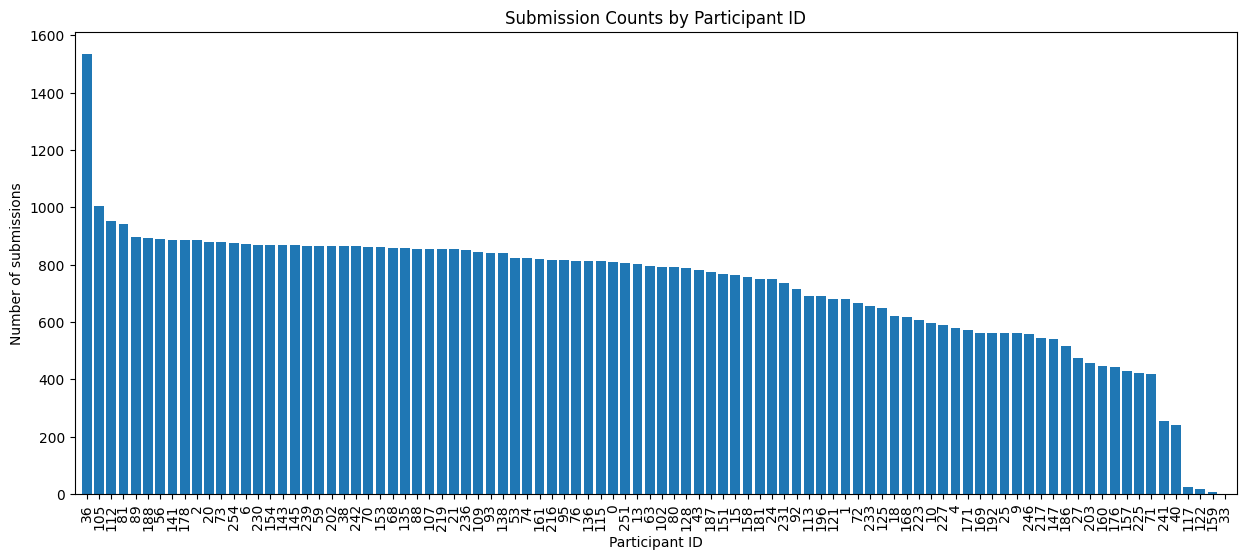

In [24]:
#The column is set to strings as it is an ID
df["participant_id"] = df["participant_id"].astype(str)

# Calculate the counts for each participant_id
counts = df["participant_id"].value_counts()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the histogram
bars = ax.bar(counts.index, counts.values)

# Set the labels and title
ax.set_xlabel("Participant ID")
ax.set_ylabel("Number of submissions")
ax.set_title("Submission Counts by Participant ID")

# Rotate the x-axis labels if needed
plt.xticks(rotation=90, ha='center')
plt.xlim(-1, 94)

# Show the plot
plt.show()

Inspect the 'SEQUENCE_ID' Column

In [25]:
df["sequence_id"].astype(str).describe().to_frame().T

,count,unique,top,freq
sequence_id,67208,67208,1816796431,1


A unique identifier for the landmark sequence. <br>
Each parquet file may contain many sequences. <br>
Every value is unique for every row.<br>

Inspect the 'PHRASE' Column

Lets examine the phrases used

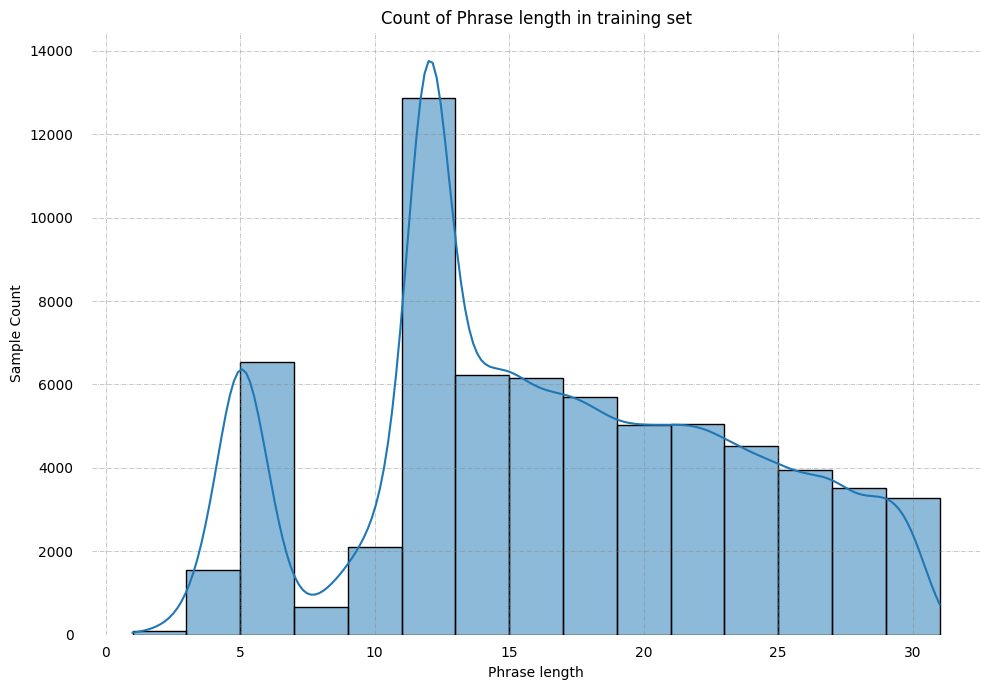

In [28]:
df['phrase_len'] = df.phrase.str.len()

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '#000000'  # very light grey

for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#ffffff'  # bluish dark grey

fig, axs = plt.subplots(1, 1, figsize=(10, 7), tight_layout=True)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)

# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')

# Add padding between axes and labels
axs.xaxis.set_tick_params(pad=5)
axs.yaxis.set_tick_params(pad=10)


# Add x, y gridlines
axs.grid(visible=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.6)

sns.histplot(df.phrase_len, kde=True, binwidth = 2)
plt.title('Count of Phrase length in training set')
plt.xlabel('Phrase length')
plt.ylabel('Sample Count')

plt.tight_layout()
plt.show()

The encoding and the characters used by the dataset

In [36]:
# Read Character to Ordinal Encoding Mapping
with open('asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)
    
# Character to Ordinal Encoding Mapping   
display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding'))

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4
&,5
',6
(,7
),8
*,9


Inspect the 'PARQUET' data file

In [37]:
sample = pd.read_parquet("asl-fingerspelling/train_landmarks/5414471.parquet")

In [38]:
print(f"Sample shape = {sample.shape}")

Sample shape = (162699, 1630)


In [39]:
print(f"Sample shape = {sample.columns}")

Sample shape = Index(['frame', 'x_face_0', 'x_face_1', 'x_face_2', 'x_face_3', 'x_face_4',
       'x_face_5', 'x_face_6', 'x_face_7', 'x_face_8',
       ...
       'z_right_hand_11', 'z_right_hand_12', 'z_right_hand_13',
       'z_right_hand_14', 'z_right_hand_15', 'z_right_hand_16',
       'z_right_hand_17', 'z_right_hand_18', 'z_right_hand_19',
       'z_right_hand_20'],
      dtype='object', length=1630)
